# Test `Dense`

Please test it with this hsl4ml fork/branch:


## Libraries

In [1]:
# Disable some console warnings on the ASIC-group servers
import os
os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [2]:
import matplotlib.pyplot as plt
import pyaml

import tensorflow as tf
from tensorflow.keras import datasets, layers, models

import keras
from keras.layers import Input
from keras.models import Sequential

from qkeras import *

## Configuration

In [3]:
RUN_HLS = True
IO_TYPE = 'io_parallel'
STRATEGY = 'Latency'
BACKEND = 'Catapult'
LAYER = 'Dense'

D_IN = 16
D_OU = 4

B = 1

FXD_W = 16 # Fixed-point precision, word bit width
FXD_I = 8 # Fixed-point precision, integer-part bit width

## QKeras

### Create qkeras model

In [4]:
def CreateQDenseModel(input_shape, units, activation=None):
    x_in = Input(shape=input_shape, name='qinput')
    
    x_out = QDense(
        units=units,
        activation=activation,
        use_bias=True,
        #initializer=tf.keras.initializers.Ones(), # makes debugging easy
        kernel_quantizer=quantized_bits(FXD_W, FXD_I-1, 1, alpha=1),
        bias_quantizer=quantized_bits(FXD_W, FXD_I-1, 1, alpha=1),
        name='qdense'
    )(x_in)

    model = Model(inputs=x_in, outputs=x_out, name='DenseModel')
    return model

In [5]:
qmodel = CreateQDenseModel(input_shape=(D_IN, ), units=D_OU)
qmodel.summary()

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
Model: "DenseModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 qinput (InputLayer)         [(None, 16)]              0         
                                                                 
 qdense (QDense)             (None, 4)                 68        
                                                                 
Total params: 68
Trainable params: 68
Non-trainable params: 0
_________________________________________________________________


### Show qkeras weights

In [6]:
# Print the weights on console
#N_WEIGHTS = 10

# Backup print options
bkp_threshold = np.get_printoptions()['threshold']
bkp_linewidth = np.get_printoptions()['linewidth']

# Set print options
np.set_printoptions(threshold=np.inf, linewidth=np.inf)

qweights = qmodel.get_weights()
for i, w in enumerate(qweights):
    print(f"Weights {i}:")
    print(w.shape)
    #print(w)
    print(w.flatten())
    print("-----------")

# Restore print options
np.set_printoptions(threshold=bkp_threshold, linewidth=bkp_linewidth)

Weights 0:
(16, 4)
[-3.41403410e-02  6.21780455e-01 -1.14449054e-01  1.27480542e-02  1.87175319e-01  3.47483724e-01 -1.03418477e-01 -1.42699718e-01 -4.94157523e-01 -1.72958914e-02  2.03840975e-02  3.54409218e-01  6.09446943e-01 -1.03246339e-01  8.62048343e-02 -1.06497310e-01 -8.82179290e-02 -4.74821299e-01  2.56194234e-01  3.21940631e-02 -3.98883581e-01 -2.18217924e-01 -2.53273517e-01  7.23569766e-02 -3.59532654e-01 -5.39231956e-01  1.39313534e-01 -6.17573500e-01 -2.17204228e-01  2.80642092e-01  6.71193600e-01  7.94390142e-02 -4.12631840e-01  2.59737432e-01 -4.11781400e-01  1.85291007e-01 -2.45292440e-01 -3.52804840e-01  1.09207012e-01  4.47916687e-02  6.20198905e-01 -5.64618595e-02  4.89676178e-01  4.78828430e-01 -6.26095161e-02 -4.30624604e-01 -7.19074979e-02  2.07508236e-01  1.83441296e-01 -5.84423363e-01 -4.22939003e-01  5.30515254e-01 -1.76617876e-01  7.83763528e-02 -5.30618883e-04 -7.15531856e-02 -5.13640285e-01 -6.33301854e-01 -1.41499445e-01 -3.01996112e-01 -4.36619371e-01  3.6

### Show qkeras model

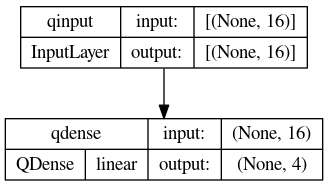

In [7]:
from tensorflow.keras.utils import plot_model
plot_model(qmodel, to_file='qkeras_model.png', show_shapes=True, show_layer_names=True, expand_nested=True, show_layer_activations=True)
#import hls4ml
#hls4ml.utils.plot.plot_model(qmodel, show_layer_names=True, show_precision=False, show_shapes=True, to_file='qkeras_model.png')

In [8]:
print_qstats(qmodel)

Instructions for updating:
Use ref() instead.


Instructions for updating:
Use ref() instead.



Number of operations in model:
    qdense                        : 64    (smult_16_8)

Number of operation types in model:
    smult_16_8                    : 64

Weight profiling:
    qdense_weights                 : 64    (16-bit unit)
    qdense_bias                    : 4     (16-bit unit)

Weight sparsity:
... quantizing model
    qdense                         : 0.0735
    ----------------------------------------
    Total Sparsity                 : 0.0735


## hls4ml

### Configure hls4ml model

In [9]:
import hls4ml

config = hls4ml.utils.config_from_keras_model(
    qmodel, 
    granularity='name',
    default_precision='fixed<{},{}>'.format(FXD_W, FXD_I)
)
config['LayerName']['qinput']['Precision']['result'] = 'fixed<{},{}>'.format(FXD_W, FXD_I)
config['LayerName']['qdense']['ReuseFactor'] = 1
config['Model']['Strategy'] = STRATEGY

# Enable tracing for all of the layers
for layer in config['LayerName'].keys():
    print('Enable tracing for layer:', layer)
    config['LayerName'][layer]['Trace'] = True

hls_model = hls4ml.converters.convert_from_keras_model(
    qmodel, 
    hls_config = config, 
    output_dir = 'myproject_prj', 
    #part = 'xcu250-figd2104-2L-e',
    backend = BACKEND,
    io_type = IO_TYPE
)

hls_model.compile()

/asic/projects/S/SMARTPIXELS/gdg/SmartPixels/hls4ml-siemens-merge/hls4ml/converters/__init__.py:27: UserWarning: WARNING: Pytorch converter is not enabled!
  warnings.warn("WARNING: Pytorch converter is not enabled!", stacklevel=1)
/asic/projects/S/SMARTPIXELS/gdg/SmartPixels/hls4ml-siemens-merge/hls4ml/converters/__init__.py:36: UserWarning: WARNING: ONNX converter is not enabled!
  warnings.warn("WARNING: ONNX converter is not enabled!", stacklevel=1)


Interpreting Model
Topology:
Layer name: qinput, layer type: InputLayer, input shapes: [[None, 16]], output shape: [None, 16]
Layer name: qdense, layer type: QDense, input shapes: [[None, 16]], output shape: [None, 4]
Enable tracing for layer: qinput
Enable tracing for layer: qdense
Enable tracing for layer: qdense_linear
Interpreting Model
Topology:
Layer name: qinput, layer type: InputLayer, input shapes: [[None, 16]], output shape: [None, 16]
Layer name: qdense, layer type: QDense, input shapes: [[None, 16]], output shape: [None, 4]
Creating HLS model
Writing HLS project
Copying NNET files to local firmware directory
... copying AC ac_types headers from /asic/projects/S/SMARTPIXELS/gdg/SmartPixels/hls4ml-siemens-merge/hls4ml/writer/../templates/catapult/ac_types/
... copying AC ac_math headers from /asic/projects/S/SMARTPIXELS/gdg/SmartPixels/hls4ml-siemens-merge/hls4ml/writer/../templates/catapult/ac_math/
... copying AC ac_simutils headers from /asic/projects/S/SMARTPIXELS/gdg/Sma

Done


In [10]:
print(pyaml.dump(config))

LayerName:
  qdense:
    Precision:
      bias: fixed<16,8,TRN,WRAP,0>
      result: fixed<16,8>
      weight: fixed<16,8,TRN,WRAP,0>
    ReuseFactor: 1
    Trace: yes
  qdense_linear:
    Precision:
      result: fixed<16,8>
    Trace: yes
  qinput:
    Precision:
      result: fixed<16,8>
    Trace: yes
Model:
  BramFactor: 1000000000
  Precision: fixed<16,8>
  ReuseFactor: 1
  Strategy: Latency
  TraceOutput: no



### Run qkeras and hls4ml simulation

In [11]:
# Set a seed to have the same input traces on every run
np.random.seed(42)

toy_data = np.random.rand(B, D_IN)
for b in range(B):
    for i in range(D_IN):
        toy_data[b][i] = b * i + i

q_toy_data = quantized_bits(FXD_W, FXD_I-1, alpha=1)(toy_data).numpy()

# Run tracing on the test set for the hls4ml model (fixed-point precision) 
hls4ml_pred, hls4ml_trace = hls_model.trace(q_toy_data)

# Run tracing on a portion of the test set for the Keras model (floating-point precision)
keras_trace = hls4ml.model.profiling.get_ymodel_keras(qmodel, q_toy_data)

Recompiling myproject with tracing
Writing HLS project
Copying NNET files to local firmware directory
... copying AC ac_types headers from /asic/projects/S/SMARTPIXELS/gdg/SmartPixels/hls4ml-siemens-merge/hls4ml/writer/../templates/catapult/ac_types/
... copying AC ac_math headers from /asic/projects/S/SMARTPIXELS/gdg/SmartPixels/hls4ml-siemens-merge/hls4ml/writer/../templates/catapult/ac_math/
... copying AC ac_simutils headers from /asic/projects/S/SMARTPIXELS/gdg/SmartPixels/hls4ml-siemens-merge/hls4ml/writer/../templates/catapult/ac_simutils/


Done
1/1 [==============================] - 0s 141ms/step
Done taking outputs for Keras model.


In [12]:
print(keras_trace)

{'qdense': array([-18.828125 , -25.445312 ,   1.5742188,   0.5703125], dtype=float32)}


### Show qkeras and hls4ml traces

In [13]:
# Print the traces on console
N_ELEMENTS=10

# Backup print options
bkp_threshold = np.get_printoptions()['threshold']
bkp_linewidth = np.get_printoptions()['linewidth']

# Set print options
np.set_printoptions(threshold=np.inf, linewidth=np.inf)

print('input', q_toy_data.flatten())
for key in hls4ml_trace.keys():
    print('-------')
    print(key, hls4ml_trace[key].shape)
    print('[qkeras]', key, keras_trace[key].flatten())
    print('[hls4ml]', key, hls4ml_trace[key].flatten())

#print(hls4ml_trace)
# Restore print options
np.set_printoptions(threshold=bkp_threshold, linewidth=bkp_linewidth)

input [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15.]
-------
qdense (1, 4)
[qkeras] qdense [-18.828125  -25.445312    1.5742188   0.5703125]
[hls4ml] qdense [-18.828125  -25.445312    1.5742188   0.5703125]


### Plot correlation qkeras and hls4ml

qdense


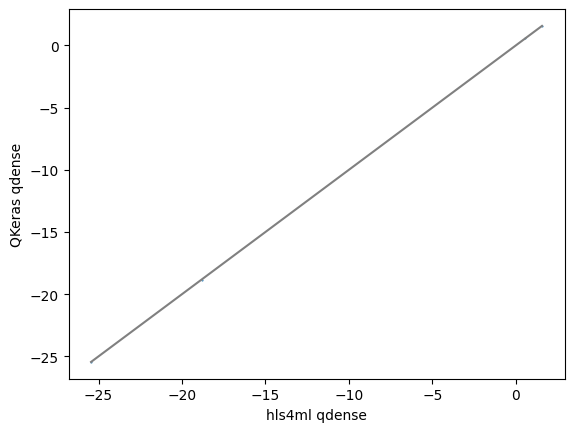

In [14]:
# Evaluate correlation plots
for layer in hls4ml_trace.keys():
    print(layer)
    if '_alpha' in layer:
        continue
    plt.figure()
    klayer = layer
    if '_linear' in layer:
        klayer = layer.replace('_linear', '')
    plt.scatter(hls4ml_trace[layer].flatten(), keras_trace[klayer].flatten(), s=0.2)
    min_x = min(np.amin(hls4ml_trace[layer]), np.amin(keras_trace[klayer]))
    max_x = max(np.amax(hls4ml_trace[layer]), np.amax(keras_trace[klayer]))
    plt.plot([min_x, max_x], [min_x, max_x], c='gray')
    plt.xlabel('hls4ml {}'.format(layer))
    plt.ylabel('QKeras {}'.format(klayer))

### Run HLS

In [15]:
report = hls_model.build(csim=False, synth=True, cosim=False, validation=False, export=False, vsynth=False, reset=False)

catapult -product ultra -shell -f build_prj.tcl -eval 'set ::argv "reset=False csim=False synth=True cosim=False validation=False export=False vsynth=False fifo_opt=False bitfile=False ran_frame=5 sw_opt=False power=False da=False vhdl=False verilog=True bup=False"'
//  Catapult Ultra Synthesis 2023.2_1/1065141 (Production Release) Mon Sep 11 19:17:22 PDT 2023
//  
//          Copyright (c) Siemens EDA, 1996-2023, All Rights Reserved.
//                        UNPUBLISHED, LICENSED SOFTWARE.
//             CONFIDENTIAL AND PROPRIETARY INFORMATION WHICH IS THE
//                   PROPERTY OF SIEMENS EDA OR ITS LICENSORS.
//  
//  Running on Linux gdg@fasic-beast1.fnal.gov 3.10.0-1160.105.1.el7.x86_64 x86_64 aol
//  
//  Package information: SIFLIBS v26.2_1.0, HLS_PKGS v26.2_1.0, 
//                       SIF_TOOLKITS v26.2_1.0, SIF_XILINX v26.2_1.0, 
//                       SIF_ALTERA v26.2_1.0, CCS_LIBS v26.2_1.0, 
//                       CDS_PPRO v2023.1_3, CDS_DesignChecker v2023.